In [1]:
# imports 
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 

In [2]:
annotated_data = pd.read_csv("../annotated/re_annotated_test_data.csv")
messages_list = annotated_data["text"].astype(str).tolist()

##### Zero-shot stance classification

In [3]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

/home/jnye/miniconda3/envs/bach_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


In [4]:
sequence_to_classify = messages_list
candidate_labels = ['for', 'against', 'neutral']
hypothesis_template = "The stance on abortion expressed by this statement is {}"
outputs = classifier(sequence_to_classify, candidate_labels, hypothesis_template=hypothesis_template)

In [5]:
outputs

[{'sequence': 'Because pro life is a ridiculous position that is not held in any consistent manner. Like pro life advocates not supporting open access to birth control or women’s health. Or not openly opposing IVF in the same way as abortion.',
  'labels': ['against', 'for', 'neutral'],
  'scores': [0.4835546612739563, 0.278573602437973, 0.23787175118923187]},
 {'sequence': "You know, you're actually making some good arguments. Well done! I'm going to take some time to digest what you're saying. I'm not sure I fully agree with everything you're saying, but I'm impressed with your argument.  You mentioned expanding abortion access. Do you feel like that's something Republicans support or oppose?",
  'labels': ['for', 'neutral', 'against'],
  'scores': [0.6634532809257507, 0.1795615702867508, 0.15698522329330444]},
 {'sequence': 'You’re saying born people have more rights than an unborn person who can’t even speak for themselves ? When do rights come into play? Is it only after you’re bo

In [8]:
true_labels = annotated_data["annotated_stance"]
predicted_labels = [output['labels'][0] for output in outputs]

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}") # 0.41

Accuracy: 0.4100


In [9]:
f1 = f1_score(true_labels, predicted_labels, average = "macro")
print(f"F1 score: {f1:.4f}") # 0.331

F1 score: 0.3319


In [12]:
precision = precision_score(true_labels, predicted_labels, average = "macro")
print(f"precision: {precision:.4f}") 

precision: 0.2780


In [13]:
recall = recall_score(true_labels, predicted_labels, average = "macro")
print(f"recall: {recall:.4f}") 

recall: 0.4142


Accuracy: 0.2700 for hypothesis_template = "This statement expresses a {} opinion"


Accuracy: 0.3550 for hypothesis_template = "This statement expresses a {} opinion on the topic of abortion"

##### Few-shot classification

##### Setfit 

In [4]:
# getting the data 
from datasets import load_dataset
dataset = load_dataset('csv', data_files={'train': '../annotated/re_annotated_train_data.csv', 'test': '../annotated/re_annotated_test_data.csv'})

# dataset = load_dataset("csv", data_files="annotated/annotated_train_data.csv")
dataset = dataset.rename_column("annotated_stance", "label")
# dataset = dataset.rename_column("w", "text")
dataset = dataset.remove_columns(['Column1', 'Topic', 'Name', "Unnamed: 0"])
train_dataset = dataset["train"]
test_dataset = dataset["test"]

label_map = {"for": 0, "neutral": 1, "against": 2}
train_dataset = train_dataset.map(lambda row: {"label": label_map[row["label"]]})
test_dataset = test_dataset.map(lambda row: {"label": label_map[row["label"]]})

print(train_dataset.to_pandas().head())
print(test_dataset.to_pandas().head())

Map: 100%|██████████| 100/100 [00:00<00:00, 13431.23 examples/s]

   Unnamed: 0.1                                               text  label
0             0  It really is not.   There is also a difference...      2
1             1  The metaphor would actually be if they tripped...      2
2             2  Yeah, their arguments are silly to say the lea...      2
3             3  Some would say the same about the opposite sid...      2
4             4  Nationally, the abortions didn't go down.   Co...      0
   Unnamed: 0.1                                               text  label
0             0  Because pro life is a ridiculous position that...      0
1             1  You know, you're actually making some good arg...      1
2             2  You’re saying born people have more rights tha...      2
3             3   No, we aren't. An embryo is not "a child".  A...      0
4             4  It is part of the mother. Individual entities ...      0


In [22]:
train_dataset.select(range(5)) 
test_dataset.select(range(5)) 

print(test_dataset.to_pandas().head())


                                                text  label
0  Because pro life is a ridiculous position that...      0
1  You know, you're actually making some good arg...      2
2  You’re saying born people have more rights tha...      2
3   No, we aren't. An embryo is not "a child".  A...      0
4  It is part of the mother. Individual entities ...      0


In [21]:
import torch
predictions = torch.tensor([[0.1859, 0.8141],
                            [0.1987, 0.8013],
                            [0.1912, 0.8088],
                            [0.1873, 0.8127],
                            [0.1954, 0.8046]], dtype=torch.float64)
df = pd.DataFrame(predictions, columns=[f"Logit_Class_{i}" for i in range(predictions.shape[1])])
df

,Logit_Class_0,Logit_Class_1
0,0.1859,0.8141
1,0.1987,0.8013
2,0.1912,0.8088
3,0.1873,0.8127
4,0.1954,0.8046


In [1]:
from setfit import SetFitModel
model = SetFitModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# model = SetFitModel.from_pretrained("BAAI/bge-small-en-v1.5")

/home/jnye/miniconda3/envs/bach_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [9]:
model.labels = ["for", "against", "nuetral"]

In [10]:
from setfit import TrainingArguments

args = TrainingArguments(
    batch_size=8,
    num_epochs=3,
)

In [11]:
from setfit import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
)

In [12]:
trainer.train()

***** Running training *****
  Num unique pairs = 26606
  Batch size = 8
  Num epochs = 3


Step,Training Loss
1,0.407200


: 

### Confusion matrix and metrics for SetFit

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = np.array([
[25,  3,  4], 
[14, 14,  6], 
[14,  5, 15]
])
print(cm)

def macro_f1_func(cm):
    precision = []
    recall = []
    f1_scores = []

    for i in range(len(cm)):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
        
        precision.append(prec)
        recall.append(rec)
        f1_scores.append(f1)

    macro_f1 = np.mean(f1_scores)
    macro_recall = np.mean(recall)
    macro_precision = np.mean(precision)
    return macro_f1, macro_precision, macro_recall
print(macro_f1_func(cm))

[[25  3  4]
 [14 14  6]
 [14  5 15]]
(np.float64(0.5322366234629445), np.float64(0.5693539165237279), np.float64(0.5447303921568627))


In [12]:
# f1 score for llama 
cm_llama = np.array([
[20,  7,  5], 
[7, 26,  1], 
[8,  10, 16]
])
print(macro_f1_func(cm_llama))

(np.float64(0.6145893907087937), np.float64(0.6344508204973321), np.float64(0.6200980392156863))


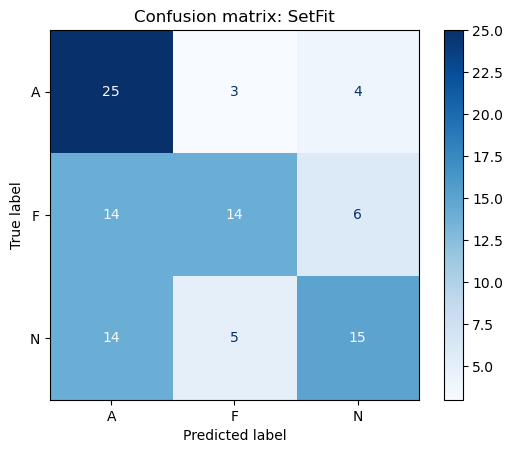

In [14]:
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "F", "N"])
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer formatting
 
plt.title("Confusion matrix: SetFit")
plt.show()

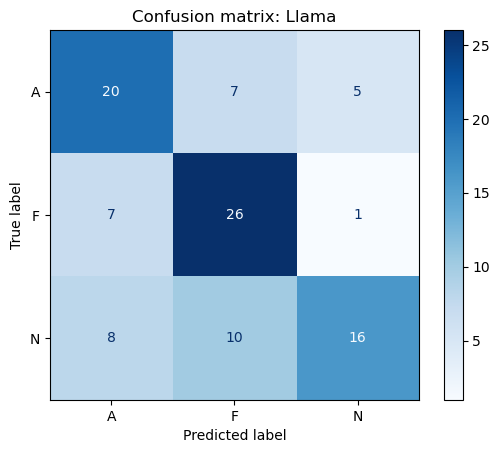

In [15]:
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_llama, display_labels=["A", "F", "N"])
disp2.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion matrix: Llama")
plt.show()

## Llama 

In [ ]:
from huggingface_hub import login

# Log in using your Hugging Face access token (hidden in public version of repo)
login("") 

/home/jnye/miniconda3/envs/bach_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import transformers
import torch

model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)

messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]

outputs = pipeline(
    messages,
    max_new_tokens=256,
)
print(outputs[0]["generated_text"][-1])

ImportError: Using `low_cpu_mem_usage=True` or a `device_map` requires Accelerate: `pip install 'accelerate>=0.26.0'`